In [1]:
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from twitter.models import *
import parliament.models as pms

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime

In [2]:
# Number of replies
Status.objects.filter(in_reply_to_status__isnull=False).count()

1251591

In [3]:
# Number of tweets by parliamentarians
pt = Status.objects.filter(author__monitoring=True)
pt.count()

1287430

In [4]:
# Coal tweets by parliamentarians
kp = Status.objects.filter(author__monitoring=True,text__icontains="Kohle")
kp.count()

6634

In [5]:
# Replies to coal tweets by parliamentarians
Status.objects.filter(in_reply_to_status__in=kp).count()

842

In [6]:
# Replies from non-parliamentarians to coal tweets by parliamentarians
Status.objects.filter(in_reply_to_status__in=kp,author__monitoring=False).count()

743

In [7]:
# Coal tweets by parliamentarians that were retweeted 
kp.filter(retweeted_by__isnull=False).count()

116

In [8]:
# Coal tweets that were retweeted by parliamentarians
statuses = Status.objects.filter(
    retweeted_by__monitoring=True,
    text__icontains="kohle"
)

statuses.count()

789

In [9]:
status_rts = statuses.annotate(
    n=Count('retweeted_by__pk')
)
status_rts.order_by('-n').values('n','text')

<QuerySet [{'text': 'Auch ohne die 20 dreckigsten Kohlekraftwerke ist die deutsche Energieversorgung sicher und die Preise bleiben stabi… https://t.co/1l7lhZu0OB', 'n': 6}, {'text': 'Kohlestrom schadet. Der Gesundheit. Dem Klima. Dem Geldbeutel. Deswegen: Die dreckigsten Meiler direkt abschalten!… https://t.co/dvxML1DJZq', 'n': 6}, {'text': 'Die #Klimakrise wartet nicht. Wir müssen den #Kohleausstieg jetzt einleiten. Macht das deutlich und kommt mit uns a… https://t.co/2mHfkwVY3l', 'n': 6}, {'text': 'Es gibt in Deutschland mehr Erneuerbare-Energien-Unternehmen als Braunkohle-Beschäftigte. Und dennoch erlaubt die B… https://t.co/lMf0kjjCmH', 'n': 4}, {'text': 'Unser Vorstand solidarisiert sich mit #HambiBleibt. Jetzt gilt reden statt roden. Die #Kohlekommission kann nicht e… https://t.co/HIMBV0Ys9W', 'n': 4}, {'text': 'Worauf warten wir noch? \n#Jamaica #Kohleausstieg https://t.co/mB3G1dOB4e', 'n': 4}, {'text': 'Dreckiger Kohlestrom im Überfluss blockiert die Erneuerbaren. Das zeigt ein

In [10]:
statuses.first().text

'Nach #KMW -Hauptversammlung: Projekt Mainzer #Kohlekraftwerk endgültig beerdigt. http://t.co/Iplo3HUH'

In [11]:
# Which parliamentarians tweet the most about coal

byauth = kp.filter(author__person__isnull=False).values('author__person').annotate(
    n = Count('pk')
).order_by('-n').values(
    'author__person__clean_name',
    'author__person__party__name',
    'author__person__party__colour',
    'n')

byauth

<QuerySet [{'author__person__clean_name': 'Dr. Julia Verlinden', 'author__person__party__name': 'gruene', 'author__person__party__colour': '#64A12D', 'n': 376}, {'author__person__clean_name': 'Oliver Krischer', 'author__person__party__name': 'gruene', 'author__person__party__colour': '#64A12D', 'n': 365}, {'author__person__clean_name': 'Annalena Baerbock', 'author__person__party__name': 'gruene', 'author__person__party__colour': '#64A12D', 'n': 266}, {'author__person__clean_name': 'Lorenz Gösta Beutin', 'author__person__party__name': 'linke', 'author__person__party__colour': '#8C3473', 'n': 184}, {'author__person__clean_name': 'Hubertus Zdebel', 'author__person__party__name': 'linke', 'author__person__party__colour': '#8C3473', 'n': 117}, {'author__person__clean_name': 'Jürgen Trittin', 'author__person__party__name': 'gruene', 'author__person__party__colour': '#64A12D', 'n': 111}, {'author__person__clean_name': 'Stephan Kühn (Dresden)', 'author__person__party__name': 'gruene', 'author_

In [12]:
adf = pd.DataFrame.from_dict([
    {
        "person": x['author__person__clean_name'],
        "tweets": x['n'],
        "party": x['author__person__party__name'],
        "col": x['author__person__party__colour']
    } 
    for x in byauth
])

adf.head()

,col,party,person,tweets
0,#64A12D,gruene,Dr. Julia Verlinden,376
1,#64A12D,gruene,Oliver Krischer,365
2,#64A12D,gruene,Annalena Baerbock,266
3,#8C3473,linke,Lorenz Gösta Beutin,184
4,#8C3473,linke,Hubertus Zdebel,117


In [13]:
adf.head(50)

,col,party,person,tweets
0,#64A12D,gruene,Dr. Julia Verlinden,376
1,#64A12D,gruene,Oliver Krischer,365
2,#64A12D,gruene,Annalena Baerbock,266
3,#8C3473,linke,Lorenz Gösta Beutin,184
4,#8C3473,linke,Hubertus Zdebel,117
5,#64A12D,gruene,Jürgen Trittin,111
6,#64A12D,gruene,Stephan Kühn (Dresden),97
7,#64A12D,gruene,Britta Haßelmann,95
8,#8C3473,linke,Sabine Leidig,86
9,#64A12D,gruene,Lisa Badum,65


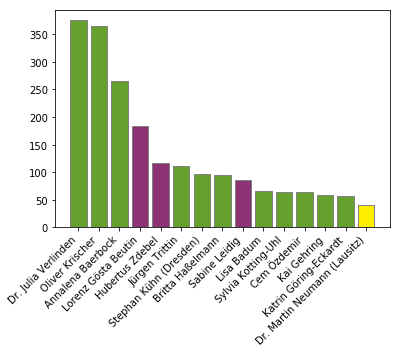

In [23]:
fig, ax = plt.subplots()

pdf = adf.head(15)

ax.bar(pdf.index,pdf['tweets'],color=pdf['col'],linewidth=1,edgecolor="grey")
ax.set_xticks(pdf.index)
ax.set_xticklabels(pdf['person'])
plt.xticks(rotation=45,ha="right")
#ax.tick_params(axis='x', rotation=45)

plt.show()

In [24]:
# Which parliamentarians tweet the most about coal

bypart = kp.filter(author__person__isnull=False).values('author__person__party').annotate(
    n = Count('pk')
).order_by('-n').values(
    'author__person__party__name',
    'author__person__party__colour',
    'n')

bypart

<QuerySet [{'author__person__party__name': 'gruene', 'author__person__party__colour': '#64A12D', 'n': 2336}, {'author__person__party__name': 'linke', 'author__person__party__colour': '#8C3473', 'n': 653}, {'author__person__party__name': 'spd', 'author__person__party__colour': '#EB001F', 'n': 270}, {'author__person__party__name': 'fdp', 'author__person__party__colour': '#FFED00', 'n': 266}, {'author__person__party__name': 'cducsu', 'author__person__party__colour': '#000000', 'n': 153}, {'author__person__party__name': 'afd', 'author__person__party__colour': '#0095e0', 'n': 102}, {'author__person__party__name': 'parteilos', 'author__person__party__colour': None, 'n': 5}]>

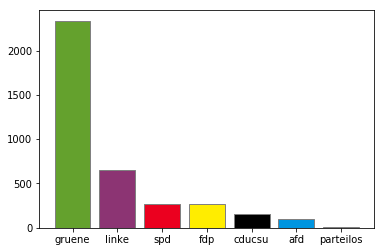

In [25]:
for x in bypart:
    if x['author__person__party__colour'] == None:
        x['author__person__party__colour'] = "white"
pdf = pd.DataFrame.from_dict([
    {
        "tweets": x['n'],
        "party": x['author__person__party__name'],
        "col": x['author__person__party__colour']
    } 
    for x in bypart
])

fig, ax = plt.subplots()

ax.bar(pdf.index,pdf['tweets'],color=pdf['col'],edgecolor="grey")
ax.set_xticks(pdf.index)
ax.set_xticklabels(pdf['party'])

plt.savefig('../plots/twitter/party_kohle_tweets.png')
plt.show()

In [17]:
## Tweets that Lisa Badum (Grüne) sent in reply to others

lb = pms.Person.objects.get(surname="Badum")

Status.objects.filter(
    author__person=lb,
    in_reply_to_status__isnull=False
).count()


198

In [18]:
## Tweets (so far collected) sent in reply to Lisa Badum

lb = pms.Person.objects.get(surname="Badum")

Status.objects.filter(
    in_reply_to_status__author__person=lb
).count()

144

In [19]:
## Tweets about coal that Lisa Badum (Grüne) sent in reply to others

lb = pms.Person.objects.get(surname="Badum")

lbcoalreplies = Status.objects.filter(
    author__person=lb,
    in_reply_to_status__isnull=False,
    text__icontains="kohle"
) | Status.objects.filter(
    author__person=lb,
    in_reply_to_status__isnull=False,
    in_reply_to_status__text__icontains="kohle"
)

print(lbcoalreplies.count())

for s in lbcoalreplies:
    print()
    print(s.in_reply_to_status.text)
    print(s.text)


14

@badulrichmartha Ich habe großen Respekt für den Wiss. Dienst des BT, aber warum die Stilllegung von Kohlekraftwerk… https://t.co/y9jpTushdB
@chrislange86 Es geht dabei um die Planungssicherheit und der Kohleausstieg wird sowieso natürlicherweise kommen (d… https://t.co/gatEAgooO5

None
@Edgar231 @GoeringEckardt Wer ohne Not Fakten gegen eine Kommission schafft die den Kohleausstieg gerade diskutiert… https://t.co/FIGNOiFJUB

@badulrichmartha @GrueneBundestag @Tagesspiegel Der #Kohleausstieg ist enorm Wichtig und auch richtig. Jedoch könne… https://t.co/38VgKHct42
@DerGerstenberg @GrueneBundestag @Tagesspiegel Wie kommst du auf Millionen?

Wir reden über #Kohleausstieg. Währenddessen schlägt #NRW im #bundesrat vor, den Ausbau von #Windenergie weiter zu… https://t.co/oVJSlmG5O9
In meinem Landkreis steht nur ein Windrad aus dem Jahr 1999. ich würde mich freuen welche dazuzubekommen aber leide… https://t.co/EpJ2FAXOid

@badulrichmartha Danke, dass ihr da seid &amp; liebe Grüße aus Wür

In [20]:
## replies about coal to Lisa Badum

lb = pms.Person.objects.get(surname="Badum")

lbcoalreplies = Status.objects.filter(
    in_reply_to_status__author__person=lb,
    text__icontains="kohle"
) | Status.objects.filter(
    in_reply_to_status__author__person=lb,
    in_reply_to_status__text__icontains="kohle"
)

print(lbcoalreplies.count())

for s in lbcoalreplies:
    print('')
    print(s.author)
    print(s.text)

45

Sven - @SvenGoe
@badulrichmartha @kohleprotest Das ist keine Kohlekommission sondern die "Kommission für Wachstum, Strukturwandel u… https://t.co/TXTjxVaH8M

Antonie Gad - @antonieschlecht
@badulrichmartha und Infoflyer gegen Links, zur Aufklärung an Schulen, will NRW entwickeln. NRW ist richtig aktiv g… https://t.co/3DWemBSx2n

Lisa Badum - @badulrichmartha
In meinem Landkreis steht nur ein Windrad aus dem Jahr 1999. ich würde mich freuen welche dazuzubekommen aber leide… https://t.co/EpJ2FAXOid

Jonas - @tunfux
@badulrichmartha Kann sie das denn, nach dem nicht mal die kleinste Einheit #Kohlekommission rechtzeitig liefert?

M🙃rte - @oOMorteOo
@badulrichmartha @GrueneBundestag in zeiten einer postmodernen antiaufklärung kein wunder.
zu dem thema findet kaum… https://t.co/0PA1kfk9GU

Michael Wahl - @deutschermichl
@badulrichmartha @ArminLaschet Das ist schon eher verbrecherisch.

Hans - @hans_s_punkt
@badulrichmartha @ArminLaschet Das ist ja als würde man AFD Politiker in Dokus zum